# Esercizio serie storica

Questo secondo esercizio richiede di effettuare un'analisi di dati di serie storica.

Leggendo il dataset `data/globaltemperatures.csv`, caricare i dati della media della temperatura nei diversi mesi dell'anno dal 1750. Plottare la serie dati, analizarne le caratteristiche (tendenza e stagionalità) e provare a fare una regressione lineare del trend (per valutarne la tendenza). Per fare regressione lineare di una timeseries è conveniente trasformare l'indice (l'asse X) in un numero che indica il numero di periodi passati dal momento inziale.

Infine provare a usare la serie storica per produrre le temperature dei successivi 10 anni.

# Indice
* [Setting](#setting)
* [Lettura dataset](#lettura)
* [Pre processing ed Esplorazione](#esplorazione)
    * [Caratteristiche principali](#)
    * [Verifica duplicati](#)
    * [Verifica missing values](#)
    * [Gestione missing values](#)
    * [Feature engineering](#)
    * [Serie storica a diverse granularità](#)
    * [Analisi distribuzione variabile di interesse](#)
    * [Analisi autocorrelazione](#)
    * [Decomposizione](#)
        * [Analisi tendenza](#)
        * [Analisi stagionalità](#)
* [Regressione lineare del trend](#)
    * [Preparazione dati](#)
    * [Implementazione modello](#)
    * [Risultati](#)
* [Previsioni con ARIMA](#arima)
    * [Preparazione dati](#)
    * [Verifica stazionarietà](#)
    * [Divisione in train e test](#)
    * [Implementazione modello](#)
    * [Analisi dei residui modello selezionato](#)
    * [Previsioni sul test set](#)
    * [Valutazione perfomances sul test set](#)
    * [Previsioni dal 2016 al 2026](#)
* [Previsioni con Prophet](#prophet)
    * [Preparazione dati](#)
    * [Divisione in train e test](#)
    * [Implementazione modello](#)
    * [Previsioni sul test set](#)
    * [Valutazione perfomances sul test set](#)
    * [Previsioni dal 2016 al 2026](#)

In [ ]:
# !pip install plotly
# !pip install pmdarima

# Setting

In [4]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import pmdarima as pm

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot

# Lettura dataset

In [5]:
df_original = pd.read_csv("data/globaltemperatures.csv")
df = df_original.copy(deep=True)
df.head()

dt  LandAverageTemperature  LandAverageTemperatureUncertainty
0  1750-01-01                   3.034                              3.574
1  1750-02-01                   3.083                              3.702
2  1750-03-01                   5.626                              3.076
3  1750-04-01                   8.490                              2.451
4  1750-05-01                  11.573                              2.072

In [6]:
!jupyter labextension install jupyterlab-plotly@4.14.3

An error occurred.
ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
See the log file for details:  /var/folders/4l/l5t6x01s767d0kxm07k6dpww0000gn/T/jupyterlab-debug-x76j3cxn.log


In [8]:
# feature LandAverageTemperature

fig = px.line(df, x=df.dt, y="LandAverageTemperature", title='Livello mensile')
fig.show()

In [87]:
# feature LandAverageTemperatureUncertainty

fig = px.line(df, x=df.dt, y="LandAverageTemperatureUncertainty", title='Livello mensile')
fig.show()

# maggiormente si va nel passato maggiore risulta essere l'incertezza sui valori di LandAverageTemperature

# Pre processing ed Esplorazione

## Caratteristiche principali

In [11]:
df.shape

(3192, 3)

In [12]:
df.dtypes

dt                                    object
LandAverageTemperature               float64
LandAverageTemperatureUncertainty    float64
dtype: object

In [13]:
df.describe(include='all')

dt  LandAverageTemperature  LandAverageTemperatureUncertainty
count         3192             3180.000000                        3180.000000
unique        3192                     NaN                                NaN
top     1750-01-01                     NaN                                NaN
freq             1                     NaN                                NaN
mean           NaN                8.374731                           0.938468
std            NaN                4.381310                           1.096440
min            NaN               -2.080000                           0.034000
25%            NaN                4.312000                           0.186750
50%            NaN                8.610500                           0.392000
75%            NaN               12.548250                           1.419250
max            NaN               19.021000                           7.880000

## Verifica duplicati

In [14]:
sum(df.duplicated())

# non ci sono duplicati

0

## Verifica missing values

In [15]:
df.isna().sum()

# sono presenti alcuni valori mancanti

dt                                    0
LandAverageTemperature               12
LandAverageTemperatureUncertainty    12
dtype: int64

In [16]:
# vengono analizzati nel dettaglio i valori mancanti

df[df.isna().any(axis=1)]

# dunque i valori mancanti si riferiscono ai primi anni della serie storica

dt  LandAverageTemperature  LandAverageTemperatureUncertainty
10  1750-11-01                     NaN                                NaN
16  1751-05-01                     NaN                                NaN
18  1751-07-01                     NaN                                NaN
21  1751-10-01                     NaN                                NaN
22  1751-11-01                     NaN                                NaN
23  1751-12-01                     NaN                                NaN
25  1752-02-01                     NaN                                NaN
28  1752-05-01                     NaN                                NaN
29  1752-06-01                     NaN                                NaN
30  1752-07-01                     NaN                                NaN
31  1752-08-01                     NaN                                NaN
32  1752-09-01                     NaN                                NaN

## Gestione missing values

In [17]:
df = df.interpolate(option='time')

# verifica grafico bontà correzione
fig = px.line(df, x=df.dt, y="LandAverageTemperature", title='Livello mensile')
fig.show()

## Feature engineering

In [18]:
# sistemazione del formato campo data

df['dt'] = pd.to_datetime(df['dt'], format='%Y/%m/%d')
df

dt  LandAverageTemperature  LandAverageTemperatureUncertainty
0    1750-01-01                   3.034                              3.574
1    1750-02-01                   3.083                              3.702
2    1750-03-01                   5.626                              3.076
3    1750-04-01                   8.490                              2.451
4    1750-05-01                  11.573                              2.072
...         ...                     ...                                ...
3187 2015-08-01                  14.755                              0.072
3188 2015-09-01                  12.999                              0.079
3189 2015-10-01                  10.801                              0.102
3190 2015-11-01                   7.433                              0.119
3191 2015-12-01                   5.518                              0.100

[3192 rows x 3 columns]

In [19]:
# aggiunta di altre feature potenzialmente utili

df['month'] = df['dt'].dt.month
df['year'] = df['dt'].dt.year
df

dt  LandAverageTemperature  LandAverageTemperatureUncertainty  \
0    1750-01-01                   3.034                              3.574   
1    1750-02-01                   3.083                              3.702   
2    1750-03-01                   5.626                              3.076   
3    1750-04-01                   8.490                              2.451   
4    1750-05-01                  11.573                              2.072   
...         ...                     ...                                ...   
3187 2015-08-01                  14.755                              0.072   
3188 2015-09-01                  12.999                              0.079   
3189 2015-10-01                  10.801                              0.102   
3190 2015-11-01                   7.433                              0.119   
3191 2015-12-01                   5.518                              0.100   

      month  year  
0         1  1750  
1         2  1750  
2         3  1750  
3         4  1750  
4         5  1750  
...     ...   ...  
3187      8  2015  
3188      9  2015  
3189     10  2015  
3190     11  2015  
3191     12  2015  

[3192 rows x 5 columns]

In [20]:
# la feature dt viene impostata come indice del dataframe

df.set_index('dt', inplace=True)

In [21]:
df.head()

LandAverageTemperature  LandAverageTemperatureUncertainty  month  \
dt                                                                             
1750-01-01                   3.034                              3.574      1   
1750-02-01                   3.083                              3.702      2   
1750-03-01                   5.626                              3.076      3   
1750-04-01                   8.490                              2.451      4   
1750-05-01                  11.573                              2.072      5   

            year  
dt                
1750-01-01  1750  
1750-02-01  1750  
1750-03-01  1750  
1750-04-01  1750  
1750-05-01  1750

## Serie storica a diverse granularità

In [22]:
# livello mensile senza missing values

fig = px.line(df, x=df.index, y="LandAverageTemperature", title='Livello mensile')
fig.show()

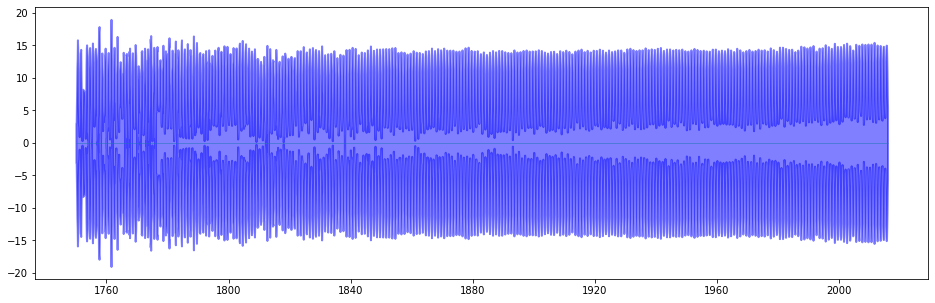

In [23]:
# grafico a specchio a livello mensile

plt.figure(figsize=(16,5))
plt.fill_between(df.index, y1=df['LandAverageTemperature'], y2=-df['LandAverageTemperature'], alpha=0.5, linewidth=2, color='blue')
plt.hlines(y=0, xmin=np.min(df.index), xmax=np.max(df.index), linewidth=.5)
plt.show()

In [24]:
# livello annuale

df_year = df[['LandAverageTemperature']].resample("Y").sum()
fig = px.line(df_year, x=df_year.index, y="LandAverageTemperature", title='Livello annuale')
fig.show()

## Analisi distribuzione variabile di interesse

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



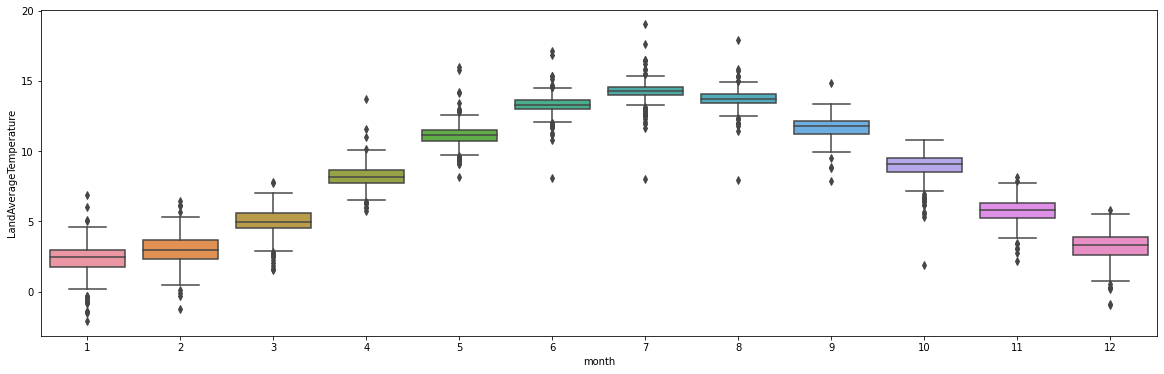

In [26]:
# a livello mensile

fig, ax = plt.subplots(figsize=(20, 6))

sns.boxplot(df['month'], df['LandAverageTemperature'])
ax.set_xlabel('month')
ax.set_ylabel('LandAverageTemperature')

plt.show()

# si nota già qui una stagionalità mensile (ripetizioni di pattern simili ogni 12 osservazioni, ovvero ogni anno), ovvero un aumento delle temperatura terrestre media nei mesi centrali dell'anno.

## Analisi autocorrelazione

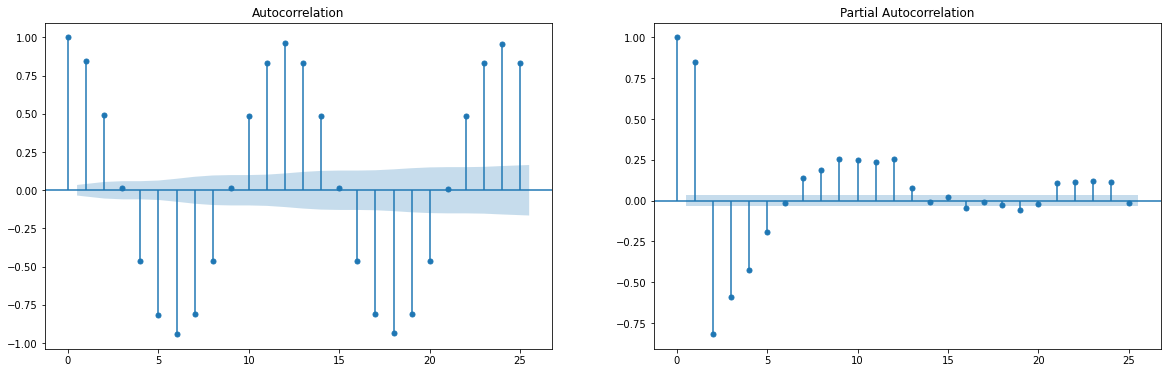

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))
plot_acf(df.LandAverageTemperature.tolist(), lags=25, ax=axes[0])
plot_pacf(df.LandAverageTemperature.tolist(), lags=25, ax=axes[1])
plt.show()

# si può notare la presenza di stagionalità come già osservato in precedenza

## Decomposizione

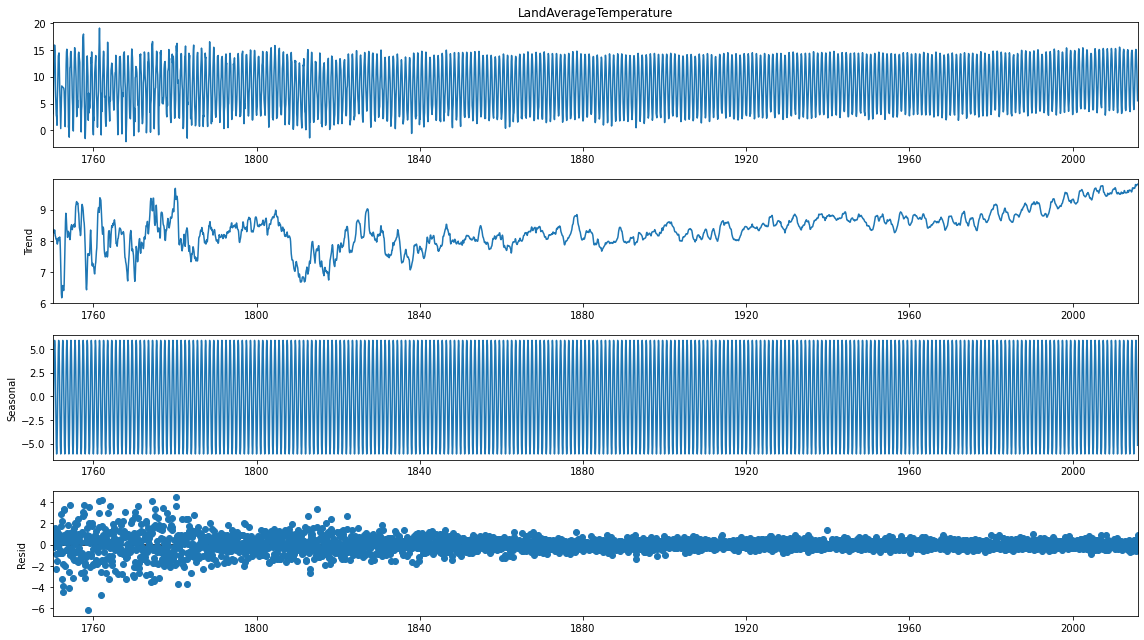

In [28]:
df_test = df.ffill()

# multiplicative Decomposition
result_add = seasonal_decompose(df_test['LandAverageTemperature'], model='additive', extrapolate_trend='freq')

# plot
plt.rcParams.update({'figure.figsize': (16, 9)})
result_add.plot()
plt.show()

### Analisi tendenza

<AxesSubplot:xlabel='dt'>

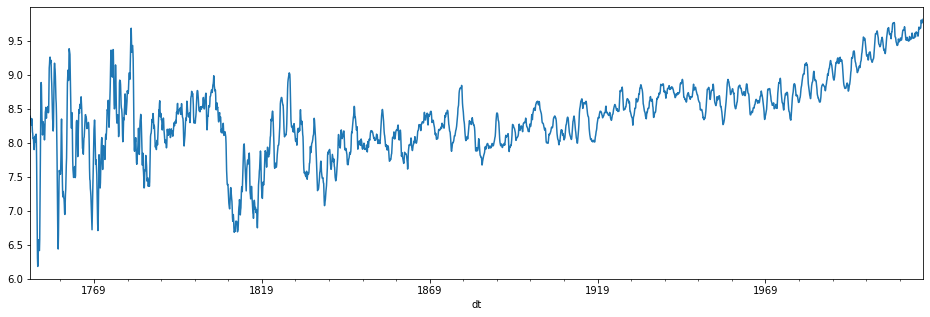

In [29]:
plt.figure(figsize=(16,5))
result_add.trend.plot(legend=False)

# si puà osservare un chiaro trend positivo

In [30]:
result_add.trend

dt
1750-01-01    8.387605
1750-02-01    8.360928
1750-03-01    8.334252
1750-04-01    8.307576
1750-05-01    8.280900
                ...   
2015-08-01    9.766115
2015-09-01    9.777700
2015-10-01    9.789285
2015-11-01    9.800871
2015-12-01    9.812456
Name: trend, Length: 3192, dtype: float64

### Analisi stagionalità

<AxesSubplot:xlabel='dt'>

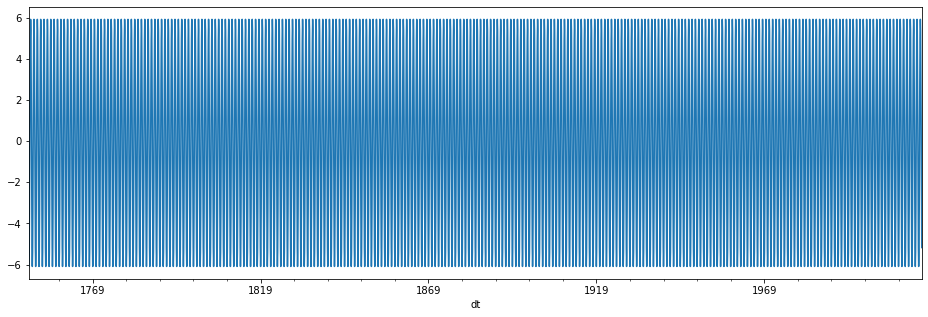

In [31]:
plt.figure(figsize=(16,5))
result_add.seasonal.plot(legend=False)

# si osserva uan forte stagionalità

In [32]:
result_add.seasonal

dt
1750-01-01   -6.093454
1750-02-01   -5.406483
1750-03-01   -3.411714
1750-04-01   -0.120741
1750-05-01    2.769936
                ...   
2015-08-01    5.365940
2015-09-01    3.335971
2015-10-01    0.508751
2015-11-01   -2.636375
2015-12-01   -5.175941
Name: seasonal, Length: 3192, dtype: float64

# Regressione lineare del trend

## Preparazione dati

In [33]:
trend_df = pd.DataFrame()
trend_df['y'] = result_add.trend
trend_df = trend_df.reset_index()
trend_df['x'] = list(range(1,3193,1))
trend_df = trend_df[['x', 'y']]

In [34]:
trend_df

x         y
0        1  8.387605
1        2  8.360928
2        3  8.334252
3        4  8.307576
4        5  8.280900
...    ...       ...
3187  3188  9.766115
3188  3189  9.777700
3189  3190  9.789285
3190  3191  9.800871
3191  3192  9.812456

[3192 rows x 2 columns]

## Implementazione modello

In [35]:
model = LinearRegression()

In [36]:
x = trend_df['x'].values
y = trend_df['y'].values

In [37]:
x = x.reshape(3192, 1)
y = y.reshape(3192, 1)

In [38]:
model  = model.fit(x, y)

## Risultati

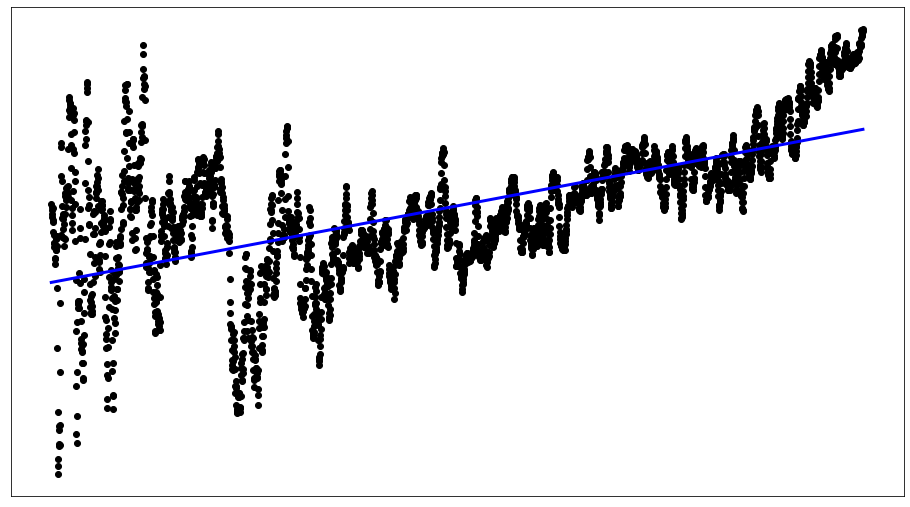

In [39]:
plt.scatter(x, y,  color='black')
plt.plot(x, model.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

# come osservato in precedenza la tendenza del trend è psotiva, in crescita

# Previsioni con ARIMA

## Preparazione dati

In [40]:
df_arima = df[['LandAverageTemperature']]
df_arima

LandAverageTemperature
dt                                
1750-01-01                   3.034
1750-02-01                   3.083
1750-03-01                   5.626
1750-04-01                   8.490
1750-05-01                  11.573
...                            ...
2015-08-01                  14.755
2015-09-01                  12.999
2015-10-01                  10.801
2015-11-01                   7.433
2015-12-01                   5.518

[3192 rows x 1 columns]

## Verifica stazionarietà

In [41]:
result = adfuller(df_arima.LandAverageTemperature)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# nonostante il trend e la stagionalità evidente il test sembra indicare che la serie sia stazionaria

ADF Statistic: -4.036404
p-value: 0.001231
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [42]:
# per completezza si prova ad eliminare trend e stagionalità

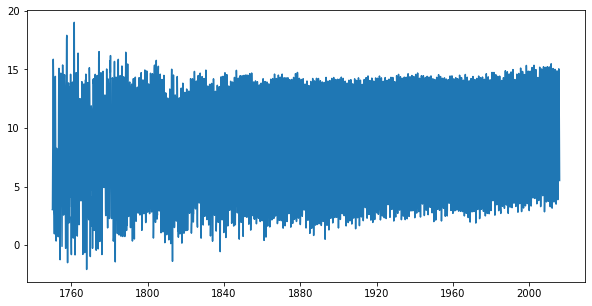

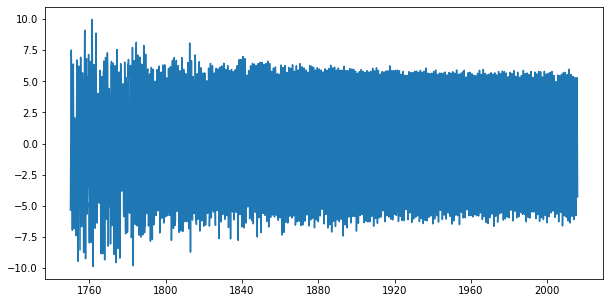

In [43]:
# viene rimosso il trend

plt.rcParams.update({'figure.figsize': (10, 5)})

df_detrend = df_arima.copy()
plt.plot(df_detrend.index, df_detrend.LandAverageTemperature)
plt.show()

result_mul = seasonal_decompose(df_detrend['LandAverageTemperature'], model='additive', extrapolate_trend='freq')
detrended = df_detrend.LandAverageTemperature.values - result_mul.trend

plt.plot(df_detrend.index, detrended)
plt.show()

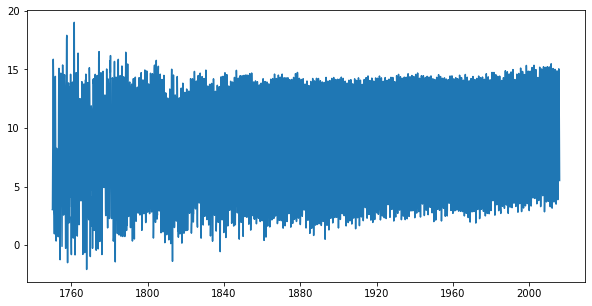

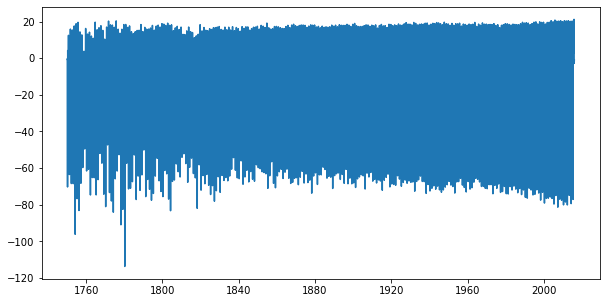

In [44]:
# viene rimossa la stagionalità

plt.rcParams.update({'figure.figsize': (10, 5)})

df_deseason = df_arima.copy()
plt.plot(df_deseason.index, df_deseason.LandAverageTemperature)
plt.show()

result_mul = seasonal_decompose(df_deseason['LandAverageTemperature'], model='additive', extrapolate_trend='freq')
deseasonalized = df_deseason.LandAverageTemperature.values / result_mul.seasonal

plt.plot(df_deseason.index, deseasonalized)
plt.show()

In [45]:
# si procede tuttavia supponendo che i dati siano stazionari

## Divisione in train e test

In [46]:
df_train = df_arima[df_arima.index < '2005-02-01'].copy()['LandAverageTemperature']

df_test = df_arima[df_arima.index >= '2005-02-01'].copy()['LandAverageTemperature']

# check sample size
print('Train: ', df_train.size)
print('Test: ', df_test.size)

Train:  3061
Test:  131


## Implementazione modello

In [40]:
smodel = pm.auto_arima(df_arima, start_p=1, start_q=1,
                       test='adf',
                       max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=6.37 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=9612.931, Time=0.17 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=8397.982, Time=1.45 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.87 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=9611.011, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=9230.828, Time=0.34 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=8150.327, Time=4.12 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=18.48 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.02 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=8568.081, Time=2.71 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=8145.469, Time=3.94 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=8394.395, Time=1.76 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=16.60 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=11.22 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=814

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 3192
Model:             SARIMAX(3, 0, 2)x(2, 1, [], 12)   Log Likelihood               -4054.682
Date:                             Sun, 26 Jun 2022   AIC                           8125.363
Time:                                     22:40:06   BIC                           8173.880
Sample:                                          0   HQIC                          8142.763
                                            - 3192                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3121      0.059     22.117      0.000       1.196       1.428
ar.L2         -0.9475      0.079    -11.987      0.000      -1.102      -0.793
ar.L3          0.1620      0.027      5.922      0.000       0.108       0.216
ma.L1         -0.9791      0.056    -17.425      0.000      -1.089      -0.869
ma.L2          0.6793      0.056     12.029      0.000       0.569       0.790
ar.S.L12      -0.5969      0.011    -56.747      0.000      -0.618      -0.576
ar.S.L24      -0.2727      0.009    -28.970      0.000      -0.291      -0.254
sigma2         0.7487      0.009     83.298      0.000       0.731       0.766
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6547.04
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
# il modello migliore ottenuto risulta essere:
# ARIMA(order=(3, 0, 2), scoring_args={}, seasonal_order=(2, 1, 0, 12), suppress_warnings=True, with_intercept=False)

model_arima = ARIMA(df_train,
             order=(3, 0, 2),
             seasonal_order=(2, 1, 0, 12))
model_arima = model_arima.fit()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



## Analisi dei residui modello selezionato

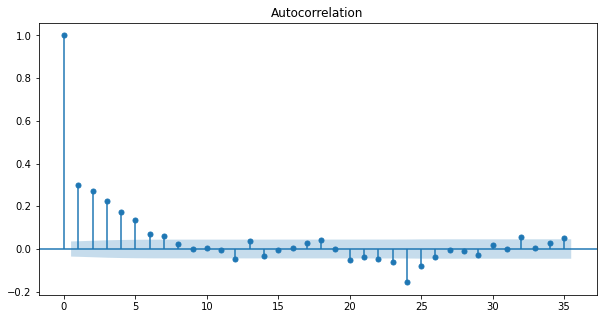

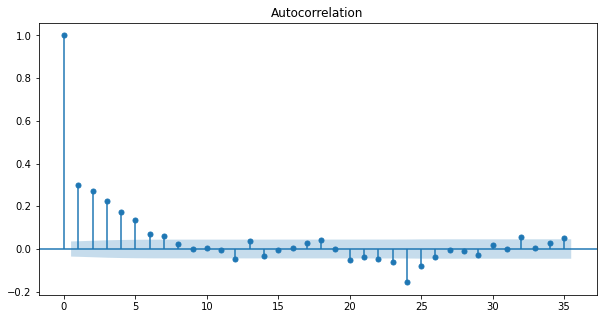

In [49]:
# analisi acf e pacf dei redsidui del modello migliore

plot_acf(model_arima.resid)

## Previsioni sul test set

In [50]:
# previsioni sul test set

pred = model_arima.get_prediction(start=df_test.index[0], end=df_test.index[-1]).predicted_mean
pred

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



2005-02-01     4.385457
2005-03-01     6.306328
2005-04-01     9.181812
2005-05-01    11.943540
2005-06-01    14.005319
                ...    
2015-08-01    14.408231
2015-09-01    12.770561
2015-10-01    10.195165
2015-11-01     7.060713
2015-12-01     4.502829
Freq: MS, Name: predicted_mean, Length: 131, dtype: float64

## Valutazione performances sul test set

/var/folders/4l/l5t6x01s767d0kxm07k6dpww0000gn/T/ipykernel_15464/1530992414.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



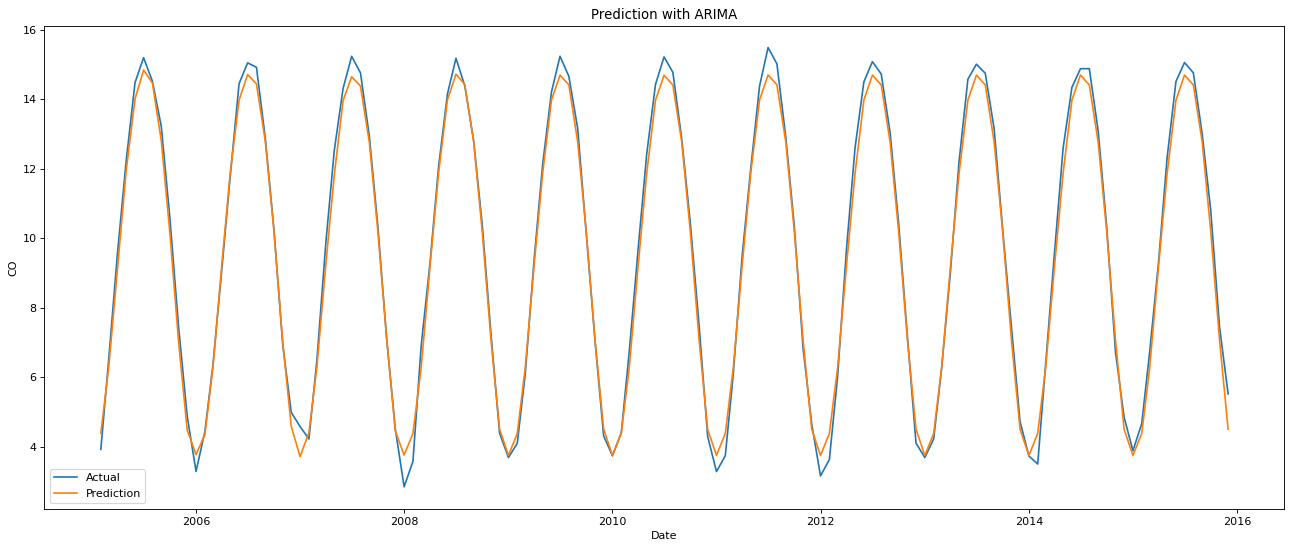

In [51]:
fig=plt.figure(figsize=(20,8), dpi=80)
fig.show()
ax=fig.add_subplot()
plt.title('Prediction with ARIMA')
plt.xlabel('Date')
plt.ylabel('CO')
ax.plot(df_test, label='Actual')
ax.plot(pred, label='Prediction')
plt.legend()
plt.show()

In [52]:
# performances sul test set

aic = model_arima.aic
mape = mean_absolute_percentage_error(df_test, pred)
print('AIC: ', int(aic))
print('MAPE:', round(mape, 4))

AIC:  7902
MAPE: 0.0441


## Previsioni dal 2016 al 2026

In [53]:
dates_future = pd.date_range(start='2016-01-01', end='2026-01-01', freq='M')
df_future = pd.DataFrame()
df_future.index = dates_future
df_future['LandAverageTemperature'] = None
df_future

LandAverageTemperature
2016-01-31                   None
2016-02-29                   None
2016-03-31                   None
2016-04-30                   None
2016-05-31                   None
...                           ...
2025-08-31                   None
2025-09-30                   None
2025-10-31                   None
2025-11-30                   None
2025-12-31                   None

[120 rows x 1 columns]

In [54]:
# previsioni dal 2016 al 2026

pred = model_arima.get_prediction(start=df_future.index[0], end=df_future.index[-1]).predicted_mean
pred

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



2016-02-01     4.381132
2016-03-01     6.275381
2016-04-01     9.199070
2016-05-01    11.853855
2016-06-01    13.968382
                ...    
2025-09-01    12.770596
2025-10-01    10.195111
2025-11-01     7.060663
2025-12-01     4.502734
2026-01-01     3.745297
Freq: MS, Name: predicted_mean, Length: 120, dtype: float64

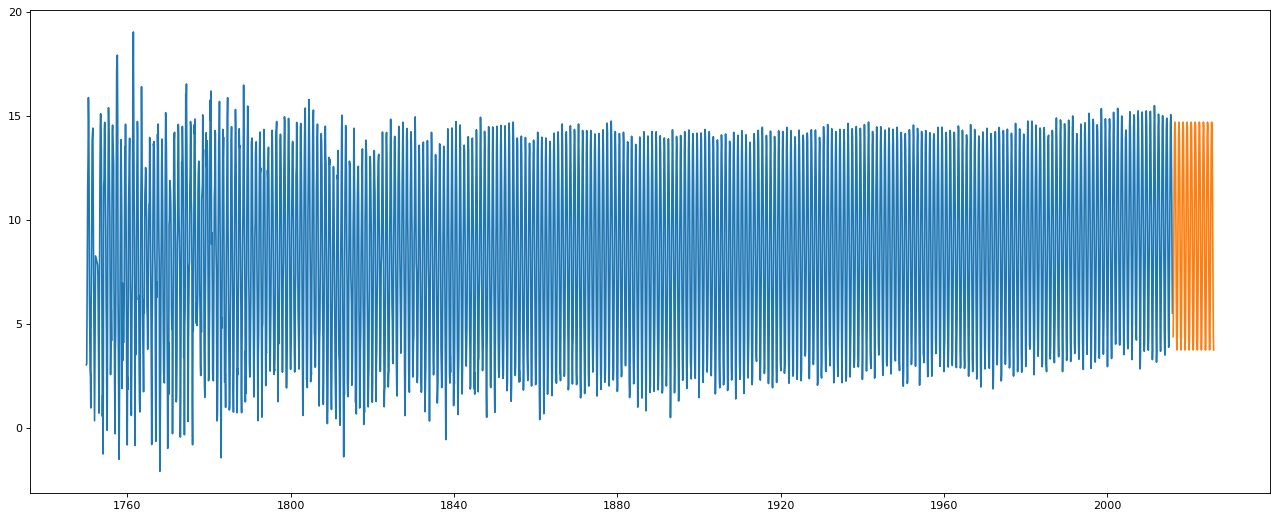

In [55]:
plt.figure(figsize=(20, 8), dpi=80)
plt.plot(df_arima['LandAverageTemperature'])
plt.plot(pred)
plt.show()

# Previsioni con Prophet

## Preparazione dati

In [56]:
df_prophet = df_arima.copy(deep=True)
df_prophet

# con Prophet non è necessario rendere stazionaria la serie

LandAverageTemperature
dt                                
1750-01-01                   3.034
1750-02-01                   3.083
1750-03-01                   5.626
1750-04-01                   8.490
1750-05-01                  11.573
...                            ...
2015-08-01                  14.755
2015-09-01                  12.999
2015-10-01                  10.801
2015-11-01                   7.433
2015-12-01                   5.518

[3192 rows x 1 columns]

In [57]:
df_prophet = df_prophet.reset_index()
df_prophet

dt  LandAverageTemperature
0    1750-01-01                   3.034
1    1750-02-01                   3.083
2    1750-03-01                   5.626
3    1750-04-01                   8.490
4    1750-05-01                  11.573
...         ...                     ...
3187 2015-08-01                  14.755
3188 2015-09-01                  12.999
3189 2015-10-01                  10.801
3190 2015-11-01                   7.433
3191 2015-12-01                   5.518

[3192 rows x 2 columns]

In [58]:
df_prophet = df_prophet.rename(columns = {'dt': 'ds', 'LandAverageTemperature':'y'})
df_prophet

ds       y
0    1750-01-01   3.034
1    1750-02-01   3.083
2    1750-03-01   5.626
3    1750-04-01   8.490
4    1750-05-01  11.573
...         ...     ...
3187 2015-08-01  14.755
3188 2015-09-01  12.999
3189 2015-10-01  10.801
3190 2015-11-01   7.433
3191 2015-12-01   5.518

[3192 rows x 2 columns]

## Divisione in train e test

In [59]:
df_prophet_train = df_prophet[df_prophet.ds < '2005-02-01'].copy()

df_prophet_test = df_prophet[df_prophet.ds >= '2005-02-01'].copy()

# check sample size
print('Train: ', df_prophet_train.size)
print('Test: ', df_prophet_test.size)

Train:  6122
Test:  262


## Implementazione modello

In [60]:
model_prophet = Prophet()
model_prophet.fit(df_prophet_train)

02:08:28 - cmdstanpy - INFO - Chain [1] start processing
02:08:29 - cmdstanpy - INFO - Chain [1] done processing


## Previsioni sul test set

In [61]:
future = model_prophet.make_future_dataframe(periods=132, freq='M')
future

ds
0    1750-01-01
1    1750-02-01
2    1750-03-01
3    1750-04-01
4    1750-05-01
...         ...
3188 2015-08-31
3189 2015-09-30
3190 2015-10-31
3191 2015-11-30
3192 2015-12-31

[3193 rows x 1 columns]

In [62]:
forecast = model_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast_values = forecast[forecast.ds >= '2005-02-01'].copy()
forecast_values = forecast_values.reset_index()

<AxesSubplot:xlabel='ds'>

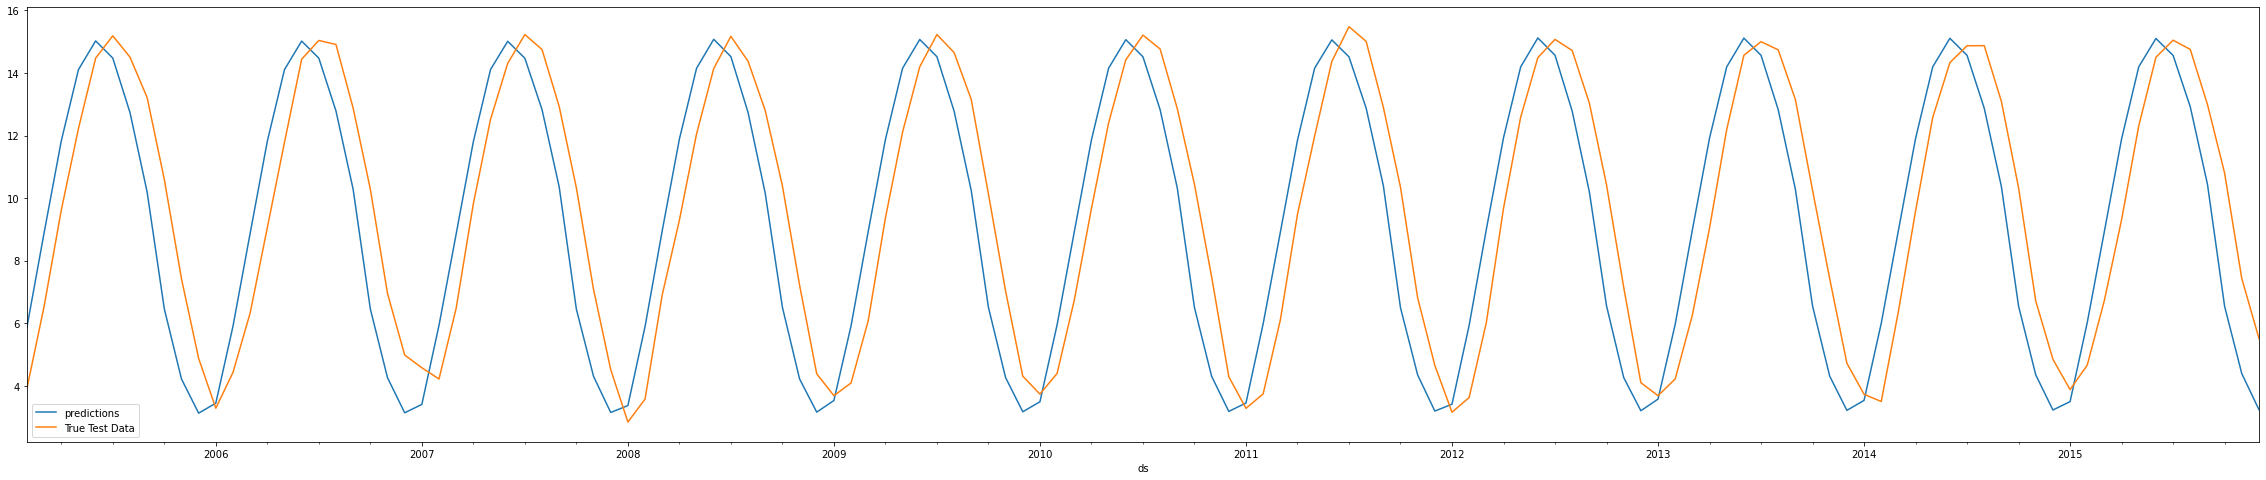

In [63]:
ax=forecast_values.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(40,8))
df_prophet_test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax)

In [64]:
df_merge = pd.DataFrame()
df_prophet_test = df_prophet_test.reset_index()
df_merge['true'] = df_prophet_test['y']
df_merge['predicted'] = forecast_values['yhat']
df_merge

true  predicted
0     3.920   5.878304
1     6.544   8.895283
2     9.618  11.830934
3    12.226  14.109003
4    14.476  15.028140
..      ...        ...
126  14.755  12.920924
127  12.999  10.448959
128  10.801   6.542534
129   7.433   4.393592
130   5.518   3.239507

[131 rows x 2 columns]

## Valutazione performances sul test set

In [65]:
y_true = df_merge['true'].values
y_pred = df_merge['predicted'].values
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
mape*100

# si ottiene un risultato migliore con il modello ARIMA in termini di MAPE

24.246888705198618

## Previsioni dal 2016 al 2026

In [66]:
model_prophet = Prophet()
model_prophet.fit(df_prophet)

02:08:34 - cmdstanpy - INFO - Chain [1] start processing
02:08:35 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
future = model_prophet.make_future_dataframe(periods=120, freq='M')

In [68]:
forecast = model_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
3307 2025-07-31  15.014163   13.924461   16.072917
3308 2025-08-31  13.285498   12.216173   14.344766
3309 2025-09-30  10.744789    9.639612   11.753466
3310 2025-10-31   7.031418    5.951345    8.066187
3311 2025-11-30   4.778301    3.760090    5.840829

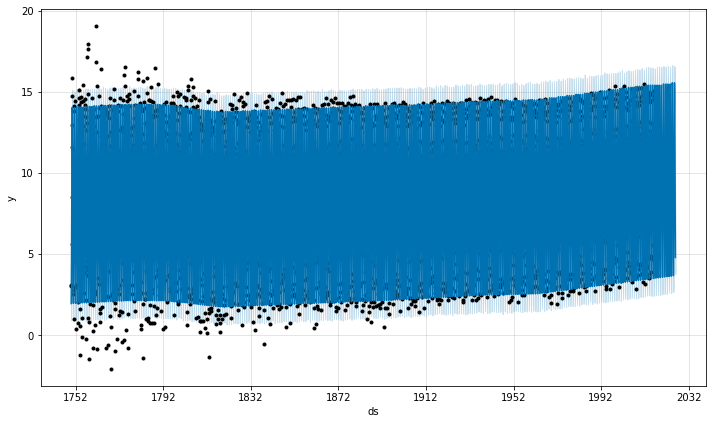

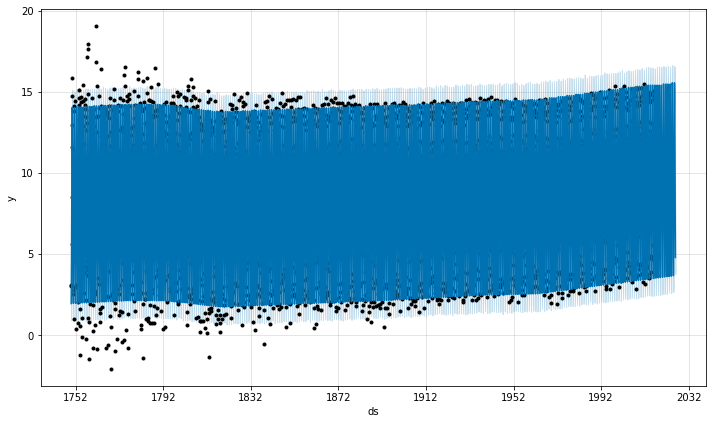

In [69]:
model_prophet.plot(forecast)

In [70]:
plot_plotly(model_prophet, forecast)

In [71]:
plot_components_plotly(model_prophet, forecast)

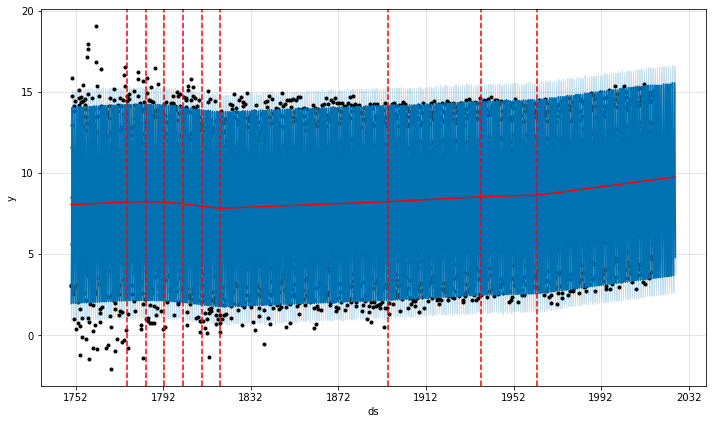

In [72]:
fig = model_prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model_prophet, forecast)